#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 feature 사용
- 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [123]:
# 모듈로딩
import torch                                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                           # 인공신경망 관련 모듈
import torch.nn.functional as F                 # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer                 # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score     # 성능지표 관련 모듈    <- 추가 설치
from torchinfo import summary                   # 모델 정보 관련 모듈   <- 추가설치

import pandas as pd                             # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split


In [124]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE  => {DEVICE}')

DEVICE  => cpu


In [125]:
torch.manual_seed(1)

In [126]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE=r'C:\Users\KDP-27\Desktop\KDT6\MachineLearning\data\iris.csv'

irisDF=pd.read_csv(DATA_FILE,usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습 방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.linear

In [127]:
# [ 모델 설계 ]
# 입력층에 입력값/피쳐 => sepal.length, sepal.width, petal.length 3개
# 출력층의 출력값/타겟 => petal.width 1개
# 입력층 : 입력 피쳐3, 출력 입력층에 존재하는 퍼셉트론 개수 10, AF ReLU
#                       ↓
#              ——————————
#              ↓ ReLU    
# 은닉층 : 입력 10, 출력 입력층에 존재하는 퍼셉트론 개수 5, AF ReLU (이전 층의 출력 값이 입력값으로 들어옴)
#                   ↓
#           —————————
#           ↓ ReLU   
# 출력층 : 입력 5, 출력 타겟/라벨 개수 1, AF - None         (이전 층의 출력 값이 입력값으로 들어옴)  

model=nn.Sequential(nn.Linear(3,10),
                    nn.ReLU(),
                    nn.Linear(10,5),
                    nn.ReLU(),
                    nn.Linear(5,1))

In [128]:
# 모델 구조 확인
print(model)

summary(model, input_size=(200000,3))

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [200000, 1]               --
├─Linear: 1-1                            [200000, 10]              40
├─ReLU: 1-2                              [200000, 10]              --
├─Linear: 1-3                            [200000, 5]               55
├─ReLU: 1-4                              [200000, 5]               --
├─Linear: 1-5                            [200000, 1]               6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 20.20
Input size (MB): 2.40
Forward/backward pass size (MB): 25.60
Params size (MB): 0.00
Estimated Total Size (MB): 28.00

In [129]:
# 가중치와 절편 확인

for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)

[0.bias] Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)

[2.weight] Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038,  0

[3] 최적화 인스턴스 준비

In [130]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(),lr=0.1)

[4] 학습 ==> 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행 하거나 또는 학습 전 진행

In [131]:
# 피쳐와 타겟 분리
featureDF=irisDF[irisDF.columns[:-1]]
targetDF=irisDF[['petal.width']]

print(featureDF.shape, targetDF.shape)

(150, 3) (150, 1)


In [132]:
# Train & Test 분할
X_train, X_test, y_train, y_test = train_test_split(featureDF,targetDF,
                                                    test_size=0.2,
                                                    random_state=5)

# Train & valid
X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,
                                                test_size=0.2, random_state=5)

print(f'[FEATURE] TRAIN { X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')



[FEATURE] TRAIN (96, 3), TEST (30, 3), VAL (24, 3)
[TARGET] TRAIN (96, 1), TEST (30, 1), VAL (24, 1)


- [4-2] 학습 진행 
    * 학습 횟수 결정 ==> 에포크 설정
    * 배치크기 결정
    * 배치개수 계산

In [133]:
EPOCH=100            # 처음부터 끝까지 공부하는 횟수
BATCH_SIZE=12                        # 1에포크에서 한 번 학습할 분량 크기
BATCH_CNT=X_train.shape[0]//BATCH_SIZE      # 1에포크에서 총 학습 횟수이면서 가중치 업데이트 횟수

print(f'EPOCH:{EPOCH}, BATCH_SIZE:{BATCH_SIZE},BATCH_CNT:{BATCH_CNT}')

EPOCH:100, BATCH_SIZE:12,BATCH_CNT:8


In [134]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행

def testing(testDF,targetDF,kind='val'):

    #Tensor화
    testTS=torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS=torch.FloatTensor(targetDF.values).to(DEVICE)

    with torch.no_grad(): #가중치 및 절편 업데이트 진행 X
        # (1) 학습진행 - forward
        pre_y=model(testTS)

        # (2) 오차 계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        
        # (3)성능평가 - R2
        r2=R2Score()(pre_y,targetTS)

        # (4) 학습결과 출력 및 저장
        print(f'{kind} LOSS : {loss}, R2:{r2}')

    return loss, r2

In [135]:
# 모델 학습 함수
def training(featureTS,targetTS,valTS, valTargetTS):
    
    loss_history=[[],[]]    #[[train],[val]]
    r2_history=[[],[]]

    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss,bs_r2=0,0

        # 배치크기 만큼 학습 진행
        for i in range(BATCH_CNT):        # (1) 학습진행 - forward
            start= i* BATCH_SIZE
            end=start+BATCH_SIZE
            # print(start, end)

            
            # BS크기 만큼만 데이터 추출해서 Tensor화 진행
            BSX_train=torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            BSy_train=torch.FloatTensor(y_train[start:end].values).to(DEVICE)

            # print(BSX_train.shape, BSX_train.device, BSX_train.dtype)
            # print(BSy_train.shape, BSy_train.device, BSy_train.dtype)


            # (1) 학습진행 -forward
            pre_y=model(BSX_train)
            print(f'pre_y.shape:{pre_y.shape}')

            # (2) 오차 계산 - 손실함수
            loss=F.mse_loss(pre_y, BSy_train)
            bs_loss+=loss.item()
            bs_r2+=R2Score()(pre_y,BSy_train).item()


            # (3) 최적화 - 가중치, 절편 업데이트 backward
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()
        
        # (4) 모델이 제대로 만들어 지는지 검사
        val_loss, val_r2=testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())


        #에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)


        
        # (5) 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] \n -TRAIN LOSS : {loss_history[0][-1]}, R2: {r2_history[0][-1]}')
        print(f' -VALID LOSS : {loss_history[1][-1]}, R2: {r2_history[1][-1]}')
    
    return loss_history, r2_history

In [136]:
# 모델 학습 진행
loss_list,r2_list=training(X_train,y_train,X_val,y_val)
loss_list

pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
val LOSS : 0.4191381633281708, R2:-0.004299283027648926
[0/100] 
 -TRAIN LOSS : 0.9069786705076694, R2: -0.5297544598579407
 -VALID LOSS : 0.4191381633281708, R2: -0.004299283027648926
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
val LOSS : 0.49096497893333435, R2:-0.17640399932861328
[1/100] 
 -TRAIN LOSS : 0.6465997360646725, R2: -0.10939279198646545
 -VALID LOSS : 0.49096497893333435, R2: -0.17640399932861328
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Siz

pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
val LOSS : 0.15743154287338257, R2:0.6227773427963257
[7/100] 
 -TRAIN LOSS : 0.1008317454252392, R2: 0.830799363553524
 -VALID LOSS : 0.15743154287338257, R2: 0.6227773427963257
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
val LOSS : 0.04897352680563927, R2:0.8826542496681213
[8/100] 
 -TRAIN LOSS : 0.07504434487782419, R2: 0.8719116225838661
 -VALID LOSS : 0.04897352680563927, R2: 0.8826542496681213
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
pre_y.shape:torch.Size([12, 1])
val LOSS : 0.029013587161898613, R2:0.9304803609848022
[9/100] 


[[0.9069786705076694,
  0.6465997360646725,
  0.6715940572321415,
  0.6003708094358444,
  0.46007593162357807,
  0.19732970278710127,
  0.07605496211908758,
  0.1008317454252392,
  0.07504434487782419,
  0.05300577008165419,
  0.04644324001856148,
  0.04479476111009717,
  0.044833490159362555,
  0.04498625104315579,
  0.04434948577545583,
  0.04325701971538365,
  0.042661872459575534,
  0.042554122395813465,
  0.042294645216315985,
  0.041758517269045115,
  0.04132198030129075,
  0.04104750556871295,
  0.04071664530783892,
  0.04036544542759657,
  0.040083488915115595,
  0.039794647600501776,
  0.03951195767149329,
  0.039265384431928396,
  0.03902175556868315,
  0.03880188474431634,
  0.038599199848249555,
  0.038413038244470954,
  0.038248631404712796,
  0.038100275909528136,
  0.037960234796628356,
  0.03752162121236324,
  0.037400985369458795,
  0.03750414028763771,
  0.03719846857711673,
  0.037370461504906416,
  0.037086402997374535,
  0.03735381213482469,
  0.03703165613114834,


In [137]:
loss_list[0]

[0.9069786705076694,
 0.6465997360646725,
 0.6715940572321415,
 0.6003708094358444,
 0.46007593162357807,
 0.19732970278710127,
 0.07605496211908758,
 0.1008317454252392,
 0.07504434487782419,
 0.05300577008165419,
 0.04644324001856148,
 0.04479476111009717,
 0.044833490159362555,
 0.04498625104315579,
 0.04434948577545583,
 0.04325701971538365,
 0.042661872459575534,
 0.042554122395813465,
 0.042294645216315985,
 0.041758517269045115,
 0.04132198030129075,
 0.04104750556871295,
 0.04071664530783892,
 0.04036544542759657,
 0.040083488915115595,
 0.039794647600501776,
 0.03951195767149329,
 0.039265384431928396,
 0.03902175556868315,
 0.03880188474431634,
 0.038599199848249555,
 0.038413038244470954,
 0.038248631404712796,
 0.038100275909528136,
 0.037960234796628356,
 0.03752162121236324,
 0.037400985369458795,
 0.03750414028763771,
 0.03719846857711673,
 0.037370461504906416,
 0.037086402997374535,
 0.03735381213482469,
 0.03703165613114834,
 0.03739803016651422,
 0.037019276060163975

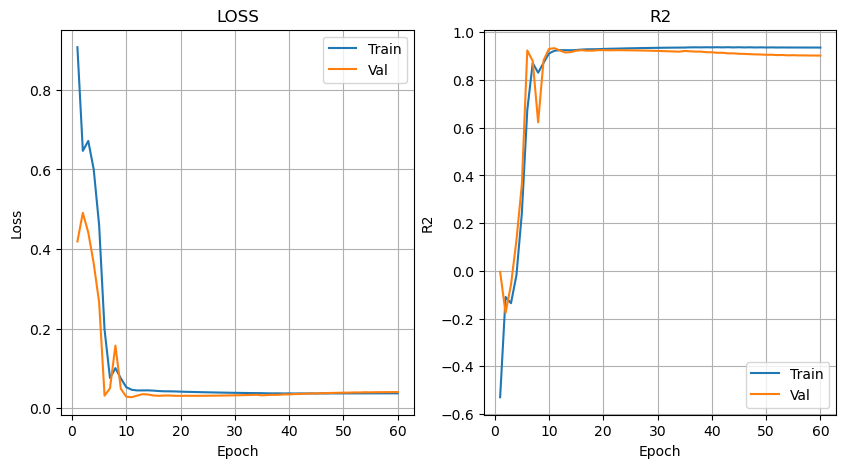

In [138]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=60

fg, axes=plt.subplots(1,2, figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), loss_list[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), loss_list[1][:THRESHOLD], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1, THRESHOLD+1), r2_list[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), r2_list[1][:THRESHOLD], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel('R2')
axes[1].set_title('R2')
plt.show()